# ML in Bioinf, Assignment Week 10, Team C
## GradientBoost Classifier

In [1]:
%pylab inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pyopenms
from pyopenms import *
import glob

Populating the interactive namespace from numpy and matplotlib


## Load the data pickle files

In [2]:
df_L_L = pd.read_csv('L_L_features.csv')
df_L_0 = pd.read_csv('L_0_features.csv')
df_L_0.head()

,0,1,2,3,4,5,6,7,8,9,...,615,616,617,618,619,620,621,622,623,624
0,0.0,0.0,0.0,0.0,0.0,2.0,14.0,14.0,11.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,7.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,5.0,9.0,11.0,16.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,9.0,14.0,14.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,8.0,16.0,30.0,15.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocess the labels to 0 for L_0_features and 1 for L_L_features

In [3]:
# get the data out of the methylationarray object, encode the cancer/normal values to 1/0
Y = pd.Series([0]*df_L_0.shape[0] + [1]*df_L_L.shape[0])
X = pd.concat([df_L_0, df_L_L])

Train_X, Test_X, Train_Y, Test_Y = train_test_split(
    X, Y, test_size=0.3, random_state=42)

# append validation to test set because we use cross validation
print("Train Shape: ",Train_X.shape)
print("Test Shape: ",Test_X.shape)

Train Shape:  (7, 625)
Test Shape:  (3, 625)


In [4]:
# Fix random seed for reproducibility
seed = 3
# np.random.seed(seed)

In [5]:
# Set parameters  

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

In [6]:
# Set parameters for cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

## Get the training accuracy and AUC using kfold cross-validation

In [7]:
probabilities = cross_val_predict(clf, Train_X, Train_Y, cv=kfold, method='predict_proba')

In [8]:
def predict_classes(probabilities):
    """Predict class labels from probabilities"""
    
    predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])
    label_binarizer = preprocessing.LabelBinarizer()
    label_binarizer.fit(range(max(predicted) + 1))
    return label_binarizer.transform(predicted)

In [9]:
print('Cross validation accuracy:')
print(metrics.accuracy_score(Train_Y, predict_classes(probabilities)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Train_Y, predict_classes(probabilities)))
tn, fp, fn, tp = metrics.confusion_matrix(Train_Y, predict_classes(probabilities)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
0.2857142857142857

Cross validation classification report

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.25      0.33      0.29         3

    accuracy                           0.29         7
   macro avg       0.29      0.29      0.29         7
weighted avg       0.30      0.29      0.29         7


Sensitivity:  0.3333333333333333

Specificity:  0.25


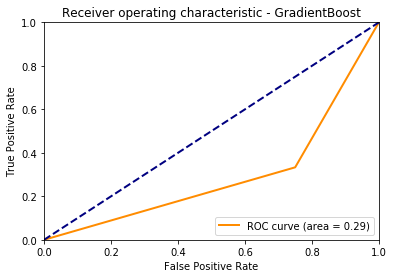

In [29]:
# Plot ROC
fpr, tpr, thresholds = metrics.roc_curve(Train_Y, predict_classes(probabilities))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - GradientBoost')
plt.legend(loc="lower right")
plt.show()

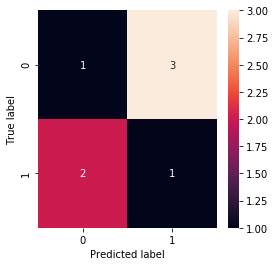

In [11]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Train_Y, predict_classes(probabilities))
class_names = sorted(Train_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Show the 18 most important features

In [12]:
# Rebuild the model
clf_fit = clf.fit(Train_X, Train_Y)

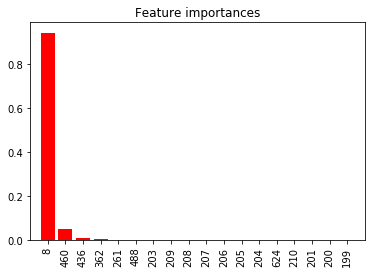

The 18 most important features are: 

Index(['8', '460', '436', '362', '261', '488', '203', '209', '208', '207',
       '206', '205', '204', '624', '210', '201', '200', '199'],
      dtype='object')


In [13]:
# Create function to determine the feature importance 
importances = clf_fit.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(18),importances[indices][:18],color="r", align="center")
plt.xticks(range(18),Train_X.T.index[indices][:18],rotation = 90)
plt.xlim([-1, 18])
plt.show()
print('The 18 most important features are: \n')
print(Train_X.T.index[indices][:18])

## Get the test data accuracy and AUC

In [14]:
# Determine performance on test set
test_prob = clf_fit.predict_proba(Test_X)

In [15]:
# Metrics for test set
print('Cross validation accuracy:')
print(metrics.accuracy_score(Test_Y, predict_classes(test_prob)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Test_Y, predict_classes(test_prob)))
tn, fp, fn, tp = metrics.confusion_matrix(Test_Y, predict_classes(test_prob)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
0.3333333333333333

Cross validation classification report

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3


Sensitivity:  0.0

Specificity:  1.0


/home/osboxes/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


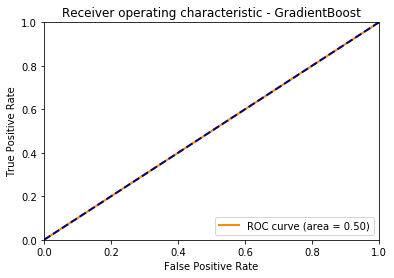

In [16]:
# Plot ROC 
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predict_classes(test_prob))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - GradientBoost')
plt.legend(loc="lower right")
plt.show()

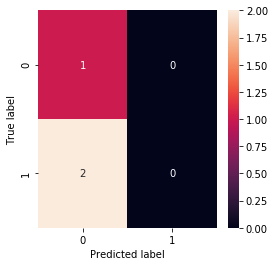

In [17]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Test_Y, predict_classes(test_prob))
class_names = sorted(Test_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Get testing accuracy again using feature selection of "r" features

In [18]:
# takes a while
maxtrain = 0
maxtest = 0
maxr = 0
for r in range(1, 50, 1):
    Train_X_select = np.take(Train_X, indices[:r], 1)
    clf_fit_select = clf.fit(Train_X_select, Train_Y)
    probabilities_select = cross_val_predict(clf, Train_X_select, Train_Y, cv=kfold, method='predict_proba')
    acctrain = metrics.accuracy_score(Train_Y, predict_classes(probabilities_select))
    Test_X_select = np.take(Test_X, indices[:r], 1)
    test_prob_select = clf_fit_select.predict_proba(Test_X_select)
    acctest =  metrics.accuracy_score(Test_Y, predict_classes(test_prob_select))
    if acctrain > maxtrain:
        if acctest > maxtest:
            maxtrain = acctrain 
            maxtest = acctest
            maxr = r
print(maxr)

9


In [19]:
r = 9

In [20]:
print('The most important features are: \n')
for i in range(r):
    print(Train_X.T.index[indices][i], "Importance: {:.6f}".format(importances[indices][i]))

The most important features are: 

8 Importance: 0.943157
460 Importance: 0.049912
436 Importance: 0.006113
362 Importance: 0.000802
261 Importance: 0.000014
488 Importance: 0.000002
203 Importance: 0.000000
209 Importance: 0.000000
208 Importance: 0.000000


In [21]:
# Rebuild the model
Train_X_select = np.take(Train_X, indices[:r], 1)
clf_fit_select = clf.fit(Train_X_select, Train_Y)

In [22]:
#Print accuracy
probabilities_select = cross_val_predict(clf, Train_X_select, Train_Y, cv=kfold, method='predict_proba')
print('Cross validation accuracy:')
print(metrics.accuracy_score(Train_Y, predict_classes(probabilities_select)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Train_Y, predict_classes(probabilities_select)))
tn, fp, fn, tp = metrics.confusion_matrix(Train_Y, predict_classes(probabilities_select)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
1.0

Cross validation classification report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7


Sensitivity:  1.0

Specificity:  1.0


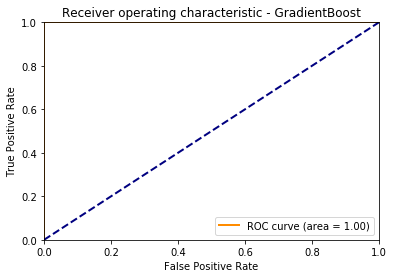

In [23]:
# Plot ROC 
fpr, tpr, thresholds = metrics.roc_curve(Train_Y, predict_classes(probabilities_select))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - GradientBoost')
plt.legend(loc="lower right")
plt.show()

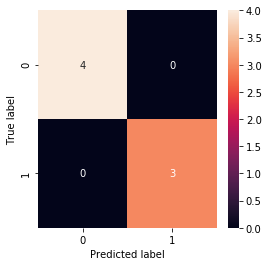

In [24]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Train_Y, predict_classes(probabilities_select))
class_names = sorted(Train_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Evaluate the feature reduced performance on the test set

In [25]:
# Determine performance on test set
Test_X_select = np.take(Test_X, indices[:r], 1)
test_prob_select = clf_fit_select.predict_proba(Test_X_select)

In [26]:
# Metrics for test set
print('Cross validation accuracy:')
print(metrics.accuracy_score(Test_Y, predict_classes(test_prob_select)))
print('\nCross validation classification report\n')
print(metrics.classification_report(Test_Y, predict_classes(test_prob_select)))
tn, fp, fn, tp = metrics.confusion_matrix(Test_Y, predict_classes(test_prob_select)).ravel()
print('\nSensitivity: ',tp / (tp+fn))
print('\nSpecificity: ',tn / (tn+fp))

Cross validation accuracy:
0.6666666666666666

Cross validation classification report

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3


Sensitivity:  0.5

Specificity:  1.0


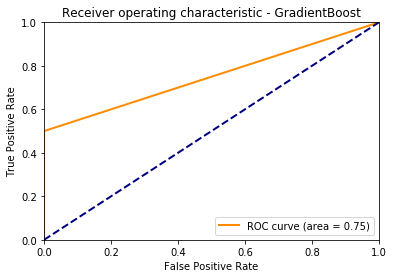

In [27]:
# Plot ROC 
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predict_classes(test_prob_select))
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - GradientBoost')
plt.legend(loc="lower right")
plt.show()

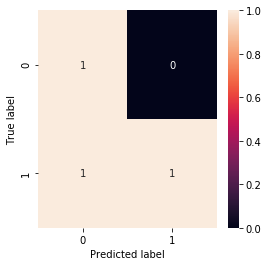

In [28]:
# Plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Test_Y, predict_classes(test_prob_select))
class_names = sorted(Test_Y.unique())
df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
fig = plt.figure(figsize=(4,4))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()